In [1]:
import numpy as np
import scipy as sp
import KTCFwd
import KTCMeshing
import KTCScoring
import KTCAux
import matplotlib.pyplot as plt
import glob
import dolfin as df

[04c0b1480f7f:05266] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


# Folders and difficulty level

In [17]:
df.set_log_level(40)

folder = 'app/'
inputFolder = folder + 'TrainingData'
truthFolder = folder + 'GroundTruths'

# Set difficulty
categoryNbr = 7

# Measurements

In [18]:
Nel = 32  # number of electrodes
z = (1e-6) * np.ones((Nel, 1))  # contact impedances
mat_dict = sp.io.loadmat(inputFolder + '/ref.mat') #load the reference data
Injref = mat_dict["Injref"] #current injections
Uelref = mat_dict["Uelref"] #measured voltages from water chamber
Mpat = mat_dict["Mpat"] #voltage measurement pattern
vincl = np.ones(((Nel - 1),76), dtype=bool) #which measurements to include in the inversion
rmind = np.arange(0,2 * (categoryNbr - 1),1) #electrodes whose data is removed

#remove measurements according to the difficulty level
for ii in range(0,75):
    for jj in rmind:
        if Injref[jj,ii]:
            vincl[:,ii] = 0
        vincl[jj,:] = 0

# Load mesh

In [19]:
# load premade finite element mesh (made using Gmsh, exported to Matlab and saved into a .mat file)
mat_dict_mesh = sp.io.loadmat(folder + 'Mesh_sparse.mat')
g = mat_dict_mesh['g'] #node coordinates
H = mat_dict_mesh['H'] #indices of nodes making up the triangular elements
elfaces = mat_dict_mesh['elfaces'][0].tolist() #indices of nodes making up the boundary electrodes

#Element structure
ElementT = mat_dict_mesh['Element']['Topology'].tolist()
for k in range(len(ElementT)):
    ElementT[k] = ElementT[k][0].flatten()
ElementE = mat_dict_mesh['ElementE'].tolist() #marks elements which are next to boundary electrodes
for k in range(len(ElementE)):
    if len(ElementE[k][0]) > 0:
        ElementE[k] = [ElementE[k][0][0][0], ElementE[k][0][0][1:len(ElementE[k][0][0])]]
    else:
        ElementE[k] = []

#Node structure
NodeC = mat_dict_mesh['Node']['Coordinate']
NodeE = mat_dict_mesh['Node']['ElementConnection'] #marks which elements a node belongs to
nodes = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC]
for k in range(NodeC.shape[0]):
    nodes[k].ElementConnection = NodeE[k][0].flatten()
elements = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT]
for k in range(len(ElementT)):
    elements[k].Electrode = ElementE[k]

#2nd order mesh data
H2 = mat_dict_mesh['H2']
g2 = mat_dict_mesh['g2']
elfaces2 = mat_dict_mesh['elfaces2'][0].tolist()
ElementT2 = mat_dict_mesh['Element2']['Topology']
ElementT2 = ElementT2.tolist()
for k in range(len(ElementT2)):
    ElementT2[k] = ElementT2[k][0].flatten()
ElementE2 = mat_dict_mesh['Element2E']
ElementE2 = ElementE2.tolist()
for k in range(len(ElementE2)):
    if len(ElementE2[k][0]) > 0:
        ElementE2[k] = [ElementE2[k][0][0][0], ElementE2[k][0][0][1:len(ElementE2[k][0][0])]]
    else:
        ElementE2[k] = []

NodeC2 = mat_dict_mesh['Node2']['Coordinate']  # ok
NodeE2 = mat_dict_mesh['Node2']['ElementConnection']  # ok
nodes2 = [KTCMeshing.NODE(coord[0].flatten(), []) for coord in NodeC2]
for k in range(NodeC2.shape[0]):
    nodes2[k].ElementConnection = NodeE2[k][0].flatten()
elements2 = [KTCMeshing.ELEMENT(ind, []) for ind in ElementT2]
for k in range(len(ElementT2)):
    elements2[k].Electrode = ElementE2[k]

Mesh = KTCMeshing.Mesh(H,g,elfaces,nodes,elements)
Mesh2 = KTCMeshing.Mesh(H2,g2,elfaces2,nodes2,elements2)

In [20]:
# Make Fenics mesh out of provided mesh

def make_Mesh(g,H):
    topological_dim = 2
    geometrical_dim = 2
    num_local_vertices = g.shape[0]
    num_global_vertices = num_local_vertices  # True if run in serial
    num_local_cells = H.shape[0]
    num_global_cells = num_local_cells

    # Create mesh object and open editor
    mesh = df.Mesh()
    editor = df.MeshEditor()
    editor.open(mesh, "triangle", topological_dim, geometrical_dim)
    editor.init_vertices_global(num_local_vertices, num_global_vertices)
    editor.init_cells_global(num_local_cells, num_global_cells)

    # Add verticess
    for i, coord in enumerate(g):
        editor.add_vertex(i, coord)

    # Add cells
    for i, cell in enumerate(H):
        editor.add_cell(i, cell)

    # Close editor
    editor.close(order = True)
    return mesh

mesh = make_Mesh(g,H)

# Define solver
Here we use the provided solver with some alterations. We use an inverse gamma noise model.

In [21]:
# set up the forward solver for inversion
solver = KTCFwd.EITFEM(Mesh2,Mesh, Injref, Mpat, vincl)
# vincl needs to be flat
vincl = vincl.T.flatten()
# set up the noise model for inversion
noise_std1 = 0.05;  # standard deviation for first noise component (relative to each voltage measurement)
noise_std2 = 0.01;  # standard deviation for second noise component (relative to the largest voltage measurement)
solver.SetInvGamma(noise_std1, noise_std2, Uelref)
mask = np.array(vincl, bool)
noisematrix = 1e-7*solver.InvGamma_n[np.ix_(mask,mask)]
solver.noisematrix = noisematrix



# Fenics classes and spaces

In [22]:
# We primarily consider the Lagrange first order
V1 = df.FunctionSpace(mesh,'CG',1)
V02 = df.VectorFunctionSpace(mesh,'DG',0)

idx = df.dof_to_vertex_map(V1)
idx2 = df.vertex_to_dof_map(V1)


class qFunction(df.UserExpression):

    def __init__(self,phi,q1,q2,**kwargs):
        super().__init__(self,**kwargs)
        self.phi = phi
        self.q1 = q1
        self.q2 = q2

    def value_shape(self):
        return ()
    
    def eval(self,values,x):
        if self.phi(x) > 0:
            values[0] = self.q1
        else:
            values[0] = self.q2

class Denom(df.UserExpression):

    def __init__(self,gradf,delta,**kwargs):
        super().__init__(self,**kwargs)
        self.phigrad = gradf
        self.delta = delta

    def value_shape(self):
        return ()

    def eval(self,values,x):
        values[0] = 1/(((self.phigrad(x)[0])**2 + (self.phigrad(x)[1])**2+self.delta)**(1/2))
        #values[0] = self.phigrad(x)[0]

class MyTV:
    def __init__(self,q0fun,delta,**kwargs):
        #self.qfun = df.project(qFunction(phi,q1,q2),V1)

        self.q0fun = q0fun
        self.q0grad = df.project(df.grad(self.q0fun),V02)
        self.q0_denom = Denom(self.q0grad,delta)

        # operator
        self.p_trial = df.TrialFunction(V1)
        self.p_test = df.TestFunction(V1)

        #self.L_op = dl.assemble(ufl.inner(self.p_trial, self.p_test)*dx)
        #self.TV_op = df.assemble(self.q_denom*ufl.inner(df.grad(self.p_trial),df.grad(self.p_test))*dx)
        self.TV_op = df.assemble((self.q0_denom*df.inner(df.grad(self.p_trial),df.grad(self.p_test)))*df.dx)

    def eval_TV(self,qfun):
        return np.dot(self.TV_op * qfun.vector(),qfun.vector())

    def eval_grad(self,qfun):
        return 2*(self.TV_op * qfun.vector())[idx2]
    
    def update_op(self,q0fun):
        self.q0fun = q0fun
        self.q0grad = df.project(df.grad(self.q0fun),V02)
        self.q0_denom = Denom(self.q0grad,delta)
        self.TV_op = df.assemble((self.q0_denom*df.inner(df.grad(self.p_trial),df.grad(self.p_test)))*df.dx) 


# Optimization problem
We try tro minimize the functional of $q=q(\phi,q_1,q_2)$
$$F(\phi,q_1,q_2)=\frac{1}{2}\|U-\mathcal{G}(q)\|^2 + \beta \int_{\Omega} |\nabla q| \, dx.$$

The gradient takes the form
$$\frac{dF}{dq}=- \nabla_q \mathcal{G}(q)^T(U-\mathcal{G}(q)) - \beta \nabla \cdot (\frac{\nabla q}{|\nabla q|})$$
In case we use a weighted 2-norm (here I mean $q^T C q$ - this is the matrix Kuopio generate with inverse gamma distribution) and use "difference" data, we have
$$F(\phi,q_1,q_2)=\frac{1}{2}\|U-U_{\mathrm{ref}}-(\mathcal{G}(q)-\mathcal{G}(0.8))\|_{C}^2 + \beta \int_{\Omega} |\nabla q| \, dx.$$ 
$$\frac{dF}{dq}=- \nabla_q \mathcal{G}(q)^TC[U-U_{\mathrm{ref}}-(\mathcal{G}(q)-\mathcal{G}(0.8))] - \beta \nabla \cdot (\frac{\nabla q}{|\nabla q|})$$ 
We assume $q_1=0.8$ and $q_2=10$ and then perform a method of gradient descent updating in the direction
$$\frac{dF}{d\phi}=\frac{dF}{dq}(q_2-q_1)\delta(\phi).$$
We approximate $\delta(\phi)$ with $\delta_\epsilon(\phi)=\frac{\epsilon}{\pi(\phi^2+\epsilon^2)}.$

##
1. Consider L^1 norm? 


In [23]:


def compute_functional(q,solver,Umeas,z,beta,idx,TV):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Solve forward problem
    Usim = solver.SolveForward2(q, z)

    # Compute TV
    R = TV.eval_TV(qfun)

    return 0.5*np.linalg.norm(Umeas-Usim)**2 + beta*R

def compute_functional2(q,solver,Umeas,Umeas_ref,z,beta,idx,TV):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Solve forward problem
    Usim = solver.SolveForward2(q, z)

    # Compute TV
    R = TV.eval_TV(qfun)

    disp = np.array((Umeas-Umeas_ref)-(Usim-solver.Uref))

    #return solver.noisematrix @ disp
    #print(disp.T)
    #print((solver.noisematrix@disp).T)
    F = 0.5 * disp.T * solver.noisematrix @ disp + beta*R
    return F[0][0]
    #return 0.5*np.inner(disp.T,(solver.noisematrix@disp).T) + beta*R
    #return 0.5*np.dot(disp.T,solver.noisematrix@disp)+ beta*R

def compute_functional2_given_disp(disp,q,solver,Umeas,Umeas_ref,beta,idx,TV):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Compute TV
    R = TV.eval_TV(qfun)

    #return solver.noisematrix @ disp
    #print(disp.T)
    #print((solver.noisematrix@disp).T)
    F = 0.5 * np.array(disp).T * solver.noisematrix @ disp + beta*R
    return F[0][0]

def find_direction(phi,q,solver,Umeas,z,beta,idx,TV,eps):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Forward map
    Usim = solver.SolveForward2(q, z)

    # Jacobian
    J = solver.Jacobian(q, z)

    # TV regularization direction
    tvdir = TV.eval_grad(qfun)

    dataterm = np.array(- J.T @ (Uel_sim - Usim)).reshape(-1)

    # Approximate delta function
    delta_eps = eps/(3.14159*(phi**2+eps**2))

    # dFdq
    dFdq = dataterm + beta*tvdir

    # Full direction
    dF = (q2-q1)*dFdq * delta_eps

    return dF

def find_direction2(phi,q,solver,Umeas,Umeas_ref,z,beta,idx,TV,eps):
    qfun = df.Function(V1)
    qfun.vector().set_local(q[idx])

    # Forward map
    Usim = solver.SolveForward2(q, z)

    # Jacobian
    J = solver.Jacobian(q, z)

    # TV regularization direction
    tvdir = TV.eval_grad(qfun)

    disp = (Umeas-Umeas_ref)-(Usim-solver.Uref)
    dataterm = np.array(- J.T @ solver.noisematrix @ (disp)).reshape(-1)

    # Approximate delta function
    delta_eps = eps/(3.14159*(phi**2+eps**2))

    # dFdq
    dFdq = dataterm + beta*tvdir

    # Full direction
    dF = (q2-q1)*dFdq * delta_eps

    return dF, disp

# Reinitialization of distance function
We need a stable way of reinitializing the level set function so that it is close to a distance function. This is crucial for the numerical stability of the algorithm.

In [24]:
# Reinitialization algorithm based on Runge-Kutta4 discretization in time direction

def reinitRK(l,idx,Niter,dt,eps,alpha):
    #phifun.vector().set_local(l[idx])

    # Set the initial value
    phi = df.TrialFunction(V1)
    phi0 = df.Function(V1)
    w = df.TestFunction(V1)
    phi1 = df.Function(V1)
    phi2 = df.Function(V1)
    phi3 = df.Function(V1)
    phi4 = df.Function(V1)
    phi_new = df.Function(V1)

    k = df.Constant(dt) # Time step Python
    phi0.vector().set_local(l[idx]) # Initial value

    epsdf = df.Constant(eps) # Interface thickness
    alphadf = df.Constant (alpha) # Numerical diffusion parameter
    sixth = df.Constant(dt/6.0)

    sign_term = phi0/ df.sqrt(phi0**2 + df.inner(df.grad(phi0),df.grad(phi0))* epsdf**2)

    a = phi*w*df.dx

    # For the heat equation:
    L1heat = - alpha * df.inner(df.grad(phi0),df.grad(w)) * df.dx
    L2heat = - alpha * df.inner(df.grad(phi0 + k/2 * phi1),df.grad(w)) * df.dx
    L3heat = - alpha * df.inner(df.grad(phi0 + k/2 * phi2),df.grad(w)) * df.dx
    L4heat = - alpha * df.inner(df.grad(phi0 + k * phi3),df.grad(w)) * df.dx


    # For the Eikonal equation:
    L1eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 ) , df.grad ( phi0 ))))* w*df.dx
    L2eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k/2 * phi1 ) , df.grad ( phi0 + k/2 * phi1 ))))* w*df.dx
    L3eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k/2 * phi2 ) , df.grad ( phi0 + k/2 * phi2 ))))* w*df.dx
    L4eik = sign_term * (1.0 - df.sqrt (df.inner( df.grad ( phi0 + k * phi3 ) , df.grad ( phi0 + k * phi3 ))))* w*df.dx


    L1 = L1heat + L1eik
    L2 = L2heat + L2eik
    L3 = L3heat + L3eik
    L4 = L4heat + L4eik

    # Boundary condition
    bc = []
    # Flag setup
    Ei = 1e10 ; E_old = 1e10
    cont = 0; num_steps = 10



    for i in range(Niter):
        
        df.solve (a == L1, phi1, bc)
        df.solve (a == L2, phi2, bc)
        df.solve (a == L3, phi3, bc)
        df.solve (a == L4, phi4, bc)


        phi_new = phi0 + sixth * (phi1 + 2*phi2 + 2*phi3 + phi4)


        # Euclidean norm
        error = ((( phi_new - phi0 )/k )**2)* df.dx
        E = df.sqrt (abs( df.assemble ( error )))
        

        # Divergence flag
        if ( E_old < E ):
            fail = 1
            print("* Diverges at reinit *", cont)
            break
        
        cont +=1
        E_old = E

        phi0.assign(phi_new)

    return phi0

# Data 
We try to load data from test 4

In [1]:
# Mesh used for image
Nimg = 256
himg = 0.23 / Nimg
mimg = -0.115 + himg
mesh_img = df.RectangleMesh(df.Point(mimg,mimg), df.Point(-mimg,-mimg), Nimg-1,Nimg-1)
V_img = df.FunctionSpace(mesh_img,'CG',1)
idx_img = df.dof_to_vertex_map(V_img)
idx_img2 = df.vertex_to_dof_map(V_img)

# Load data
mat_file = glob.glob(inputFolder + '/data3.mat')
mat_dict = sp.io.loadmat(mat_file[0])
Uel = mat_dict["Uel"]

# Load ground truth and plot
ground_truth = glob.glob(truthFolder + '/true3.mat')
truth_dict = sp.io.loadmat(ground_truth[0])

# Represent ground truth on mesh
q0_img = 20*np.flipud(truth_dict["truth"]).reshape(256**2,1)+0.8
q0 = df.Function(V_img)
q0.vector().set_local(q0_img[idx_img])
q0.set_allow_extrapolation(True)
q0 = df.interpolate(q0,V1)

# Plot
p = df.plot(q0)
plt.colorbar(p)

# Extract vector of values in the right order
q0 = q0.vector().get_local()[idx2]

# Simulate data
Uel_sim = solver.SolveForward2(q0, z)

# Initialize jacobian and reference data
JJ = solver.Jacobian(q0,z)

NameError: name 'df' is not defined

# Time for the algorithm

1. Computes direction from negative gradient
2. Picks step size from backtracking line search
3. Reinitializes level set function when it has changed 15% or 7 iterations has passed. This step also smoothenes the level set. When we do this we also update the TV class (which is essentially the weights in an L^2 weighted scheme). This is called lagged diffusion

In [26]:
# Load reference data
mat_file = glob.glob(inputFolder + '/ref.mat')
mat_dictref = sp.io.loadmat(mat_file[0])
Umeas_ref = mat_dictref["Uelref"]

# Slice data corresponding to difficulty level
Umeas = Uel[vincl]
Umeas_ref = Umeas_ref[vincl]

# Reinitialization parameters
alpha_dif = 8*1e-4 # diffusion parameter
dt = 1.5*1e-4
Ninit = 50

# TV Regularization parameter
beta = 5e-10
# TV Smoothness parameter in lagged diffusion (should be around average length of element)
delta = 1e-3

# Smoothness parameter for delta approximation and sign function in reinitializationi (should be small)
eps = 1e-3
# Step size
alpha = 0.01
# Number of iterations
Miter = 200

# Backtracking line search
#tau = 0.5
#c = 0.025

# Starting guess
r = 0.23/4
k = np.linalg.norm(g, axis=1)
phi0 = k-r
q1 = 0.8
q2 = 1e2

# Initialize level set function
phik = phi0
phi = phik
phik_new = phi

# Which becomes this:
q = q1*(phik>0) + q2*(phik<=0)

# We cast it as an CG1 function
qfun = df.Function(V1)
qfun.vector().set_local(q[idx])

# Initialize Total variation object
TV = MyTV(qfun,delta)

# Initial functional value
#F0 = compute_functional2(q,solver,Umeas,Umeas_ref,z,beta,idx,TV)

j = 0
for i in range(Miter):
    # Reinitialize step size

    dF, disp = find_direction2(phik,q,solver,Umeas,Umeas_ref,z,beta,idx,TV,eps)

    # Take a step in that direction
    phik = phik + alpha * dF
    q = q1*(phik>0) + q2*(phik<=0) 
    qfun.vector().set_local(q[idx])
    F = compute_functional2_given_disp(disp,q,solver,Umeas,Umeas_ref,beta,idx,TV)
    #F = compute_functional2(q,solver,Umeas,Umeas_ref,z,beta,idx,TV)
    
    if i == 5:
        alpha = alpha/4
        print("Updating stepsize =", alpha)
    if i == 20:
        alpha = alpha/2
        print("Updating stepsize =", alpha)
    if i == 40:
        alpha = alpha/2 
        print("Updating stepsize =", alpha)
    if i == 80:
        alpha = alpha/2
        print("Updating stepsize =", alpha)
    # Backtracking line search 
    #tt = c * np.linalg.norm(dF)**2
    #j = 0
    #while(F0-F < alpha*tt and F0-F > 1e-5):
    #    j = j+1
    #    alpha = tau*alpha
    #    phik_new = phik_new + alpha * dF
    #    q = q1*(phik_new>0) + q2*(phik_new<=0)  
    #    qfun.vector().set_local(q[idx])
    #    F = compute_functional2(q,solver,Umeas,Umeas_ref,z,beta,idx,TV)

    # Take a step of length alpha in that direction
    print("Iteration =", i, "::: Loss =", F)
    #phik = phik + alpha * dF
    #q = q1*(phik>0) + q2*(phik<=0)  
    #F0 = F
    

    # if solution is changed more than 10% we reinitialize and recompute TV object
    if np.linalg.norm(phik-phi)/np.linalg.norm(phi) > 0.10 or time_since_last >= 10:
        print("Reinitializing")
        phik = reinitRK(phik,idx,Ninit,dt,eps,alpha_dif).vector().get_local()[idx2]
        phi = phik.copy()
        q = q1*(phi>0) + q2*(phi<=0) 
        qfun.vector().set_local(q[idx])
        TV.update_op(qfun)
        time_since_last = 0
    
    time_since_last += 1





Iteration = 0 ::: Loss = [[0.4999457]]
Reinitializing
Iteration = 1 ::: Loss = [[0.37822257]]
Reinitializing
Iteration = 2 ::: Loss = [[0.27590811]]
Reinitializing
Iteration = 3 ::: Loss = [[0.19550151]]
Reinitializing
Iteration = 4 ::: Loss = [[0.14383852]]
Reinitializing
Updating stepsize = 0.0025
Iteration = 5 ::: Loss = [[0.09519847]]
Reinitializing
Iteration = 6 ::: Loss = [[0.06757219]]
Iteration = 7 ::: Loss = [[0.06165786]]
Iteration = 8 ::: Loss = [[0.06081498]]
Iteration = 9 ::: Loss = [[0.06087486]]
Iteration = 10 ::: Loss = [[0.06045634]]
Iteration = 11 ::: Loss = [[0.06045634]]
Iteration = 12 ::: Loss = [[0.06054617]]
Iteration = 13 ::: Loss = [[0.05977773]]
Iteration = 14 ::: Loss = [[0.05784649]]
Iteration = 15 ::: Loss = [[0.05783321]]
Reinitializing
Iteration = 16 ::: Loss = [[0.04987718]]
Iteration = 17 ::: Loss = [[0.04800183]]
Iteration = 18 ::: Loss = [[0.04824138]]
Iteration = 19 ::: Loss = [[0.04609944]]
Updating stepsize = 0.00125
Iteration = 20 ::: Loss = [[0.0

1.207394789509292


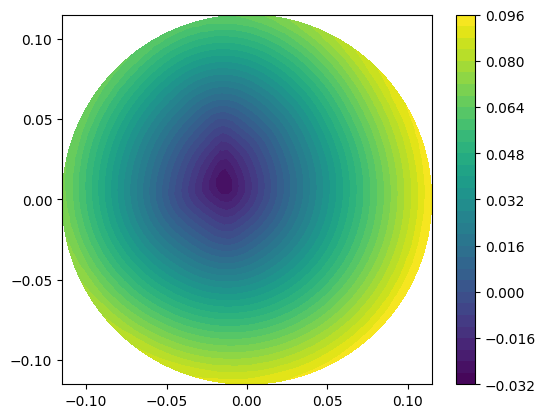

In [27]:
phik2 = reinitRK(phik,idx,Ninit,2.0*1e-4,eps,8.0*1e-4).vector().get_local()[idx2]
#phi = phik2
q = q1*(phik>0) + q2*(phik<=0) 
qfun.vector().set_local(phik[idx])

p = df.plot(qfun)
plt.colorbar(p)
print(TV.eval_TV(qfun))

/tmp/ipykernel_16280/1683895482.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q0.vector().set_local(q0_img[idx_img])


1887.5542167819235


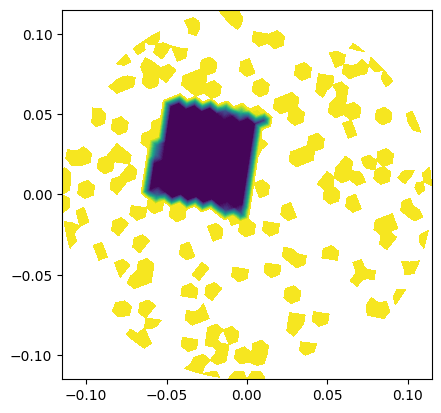

In [15]:
# Represent ground truth on mesh
q0_img = (1e-2-0.8)*np.flipud(truth_dict["truth"]).reshape(256**2,1)+0.8
q0 = df.Function(V_img)
q0.vector().set_local(q0_img[idx_img])
q0.set_allow_extrapolation(True)
q0 = df.interpolate(q0,V1)
df.plot(q0)
print(TV.eval_TV(q0))


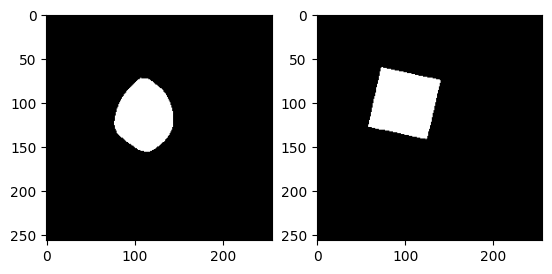

In [29]:
phi_grid = KTCAux.interpolateRecoToPixGrid(phik, Mesh)
q = 0*(phi_grid>0) + 2*(phi_grid<0)
#q[q==0.] = 0
#q[q<=q1] = 0

#mesh_img.coordinates()
#q[q<q1] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(q, cmap="gray")
ax[1].imshow(truth_dict["truth"], cmap="gray")

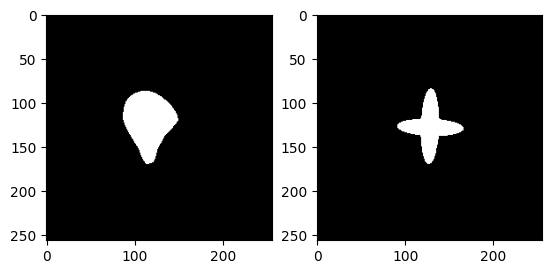

In [21]:
phi_grid = KTCAux.interpolateRecoToPixGrid(phik, Mesh)
q = 0*(phi_grid>0) + 2*(phi_grid<0)
#q[q==0.] = 0
#q[q<=q1] = 0

#mesh_img.coordinates()
#q[q<q1] = 0
fig, ax = plt.subplots(1,2)
ax[0].imshow(q, cmap="gray")
ax[1].imshow(truth_dict["truth"], cmap="gray")

# Data explorative analysis
- Image 1 has two classes: 1e-9 and 2x1e7 + 2x1e3.  
- Image 2 has two classes: 1e-9 and 2x1e7 + 2x1e3. 
- Image 3 has conductivity 2x1e7 + 2x1e3: it was a class 2
- Image 4 has conductivity 1e-9: it was a class 1

In [17]:


def load_data(datafile,truefile):

    # Load data
    mat_file = glob.glob(inputFolder + '/' + datafile)
    mat_dict = sp.io.loadmat(mat_file[0])
    Inj = mat_dict["Inj"]
    Uel = mat_dict["Uel"]
    Mpat = mat_dict["Mpat"]

    # Load reference data
    mat_file = glob.glob(inputFolder + '/ref.mat')
    mat_dictref = sp.io.loadmat(mat_file[0])
    Uel_ref = mat_dictref["Uelref"]

    # Load ground truth and plot
    ground_truth = glob.glob(truthFolder + '/' + truefile)
    truth_dict = sp.io.loadmat(ground_truth[0])

    # Represent ground truth on mesh
    q0_img = 1.0*np.flipud(truth_dict["truth"]).reshape(256**2,1)

    return q0_img, Uel, Uel_ref

def set_values(q0_img,q1,q2,q3):
    # q1 is the background
    # q2 is the resistive 
    # q3 is the conductive (which may be very high or moderate)
    q0_img2 = q0_img.copy()
    q0_img2[q0_img == 0.] = q1
    q0_img2[q0_img == 1.] = q2
    q0_img2[q0_img == 2.] = q3
    q0 = df.Function(V_img)
    q0.vector().set_local(q0_img2[idx_img])
    q0.set_allow_extrapolation(True)
    qfun = df.interpolate(q0,V1)

    # Extract vector of values in the right order
    q0vec = qfun.vector().get_local()[idx2]

    return  q0vec, qfun


/tmp/ipykernel_94117/2229720053.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q0.vector().set_local(q0_img2[idx_img])


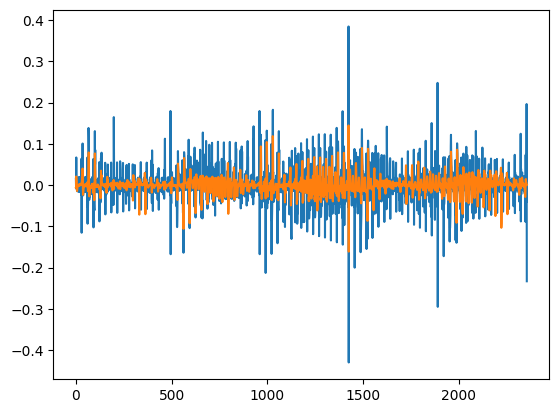

In [68]:
## Analyze systematic error
datafile = 'data1.mat'
truefile = 'true1.mat'

q1 = 0.8
q2 = 1e-9
q3 = 2*1e7 + 2*1e3

q0_img, Uel, Uel_ref = load_data(datafile,truefile)
Uel_sim_ref = solver.SolveForward2(0.8*np.ones(1602,),z)

U_sys_error = Uel_ref - Uel_sim_ref
q0vec, qfun = set_values(q0_img,q1,q2,q3)
Uel_sim = solver.SolveForward2(q0vec, z)


plt.plot(Uel-Uel_sim)
plt.plot(Uel-Uel_sim - U_sys_error)

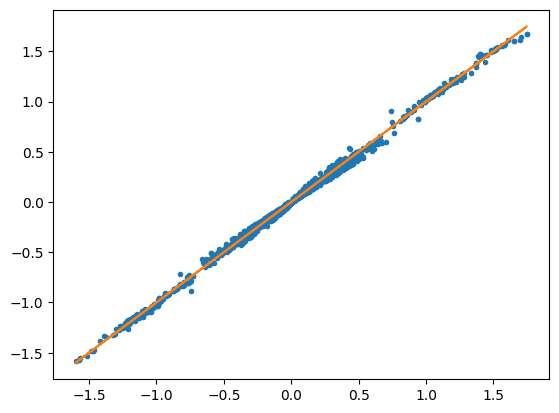

In [69]:
plt.plot(Uel,Uel_sim+U_sys_error,'.')
plt.plot(Uel,Uel)

In [61]:
# Grid search over different values

datafile = 'data3.mat'
truefile = 'true3.mat'

q0_img, Uel, Uel_ref = load_data(datafile,truefile)
Uel_sim_ref = solver.SolveForward(0.8*np.ones(1602,),z)
q1 = 0.8
q2 = 1e-9
for i in range(100):
    q3 = 2*1e7 + i*1e3
    q0vec, qfun = set_values(q0_img,q1,q2,q3)

    # Simulate data
    Uel_sim = solver.SolveForward2(q0vec, z)

    print("q3 =", i, "error =", np.linalg.norm((Uel_sim-Uel_sim_ref)-(Uel-Uel_ref)))
    

Building A0


/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/tmp/ipykernel_94117/2229720053.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q0.vector().set_local(q0_img2[idx_img])


q3 = 0 error = 0.5295144191855873
q3 = 1 error = 0.5295144427069408


KeyboardInterrupt: 

In [247]:
0.6060757339443572
0.6060759783735462
0.6060761140528538
0.606080401957933
0.6060815969252841

q0_img[q0_img == 2.] = 1

In [46]:
# Load data
mat_file = glob.glob(inputFolder + '/ref.mat')
ref_dict = sp.io.loadmat(mat_file[0])
Uel_ref = mat_dict["Uel"]

/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


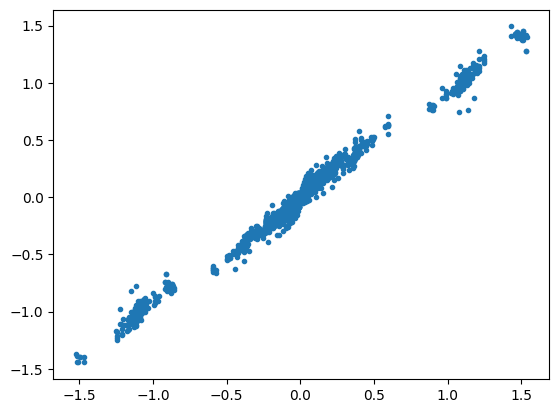

In [55]:
qfun = df.Function(V1)
qfun.vector().set_local(0.8*np.ones(V1.dim(),))

# Solve forward problem
Uref_sim = solver.SolveForward2(0.8*np.ones(V1.dim(),),z)
plt.plot(Uel_sim,Uel,'.')

/tmp/ipykernel_39041/819772686.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q0.vector().set_local(q0_img[idx_img])
/opt/conda/envs/env/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


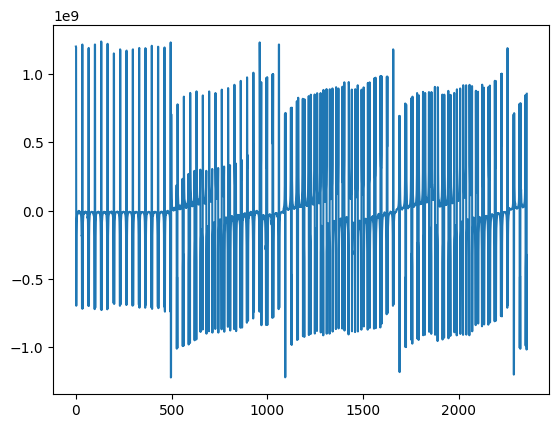

In [175]:


# Simulate data
Uel_sim = solver.SolveForward2(q0vec, z)
Uel_sim_ref = solver.SolveForward2(0*q0vec+0.8,z)

plt.plot((Uel_sim-Uel_sim_ref)-(Uel-Uel_ref))

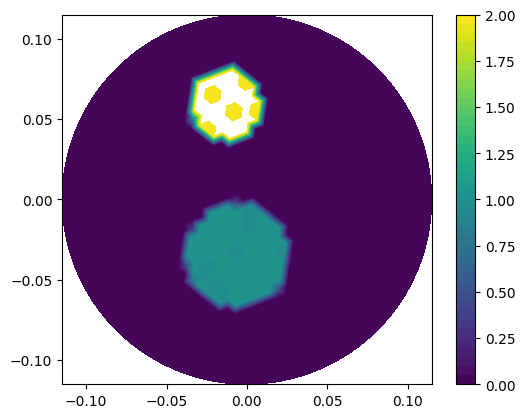

In [176]:
# Image 3 has conductivity 1e9: it was a class 2
# Image 4 has conductivity 1e-9: it was a class 1

p = df.plot(q1)
plt.colorbar(p)

In [164]:
Uel_sim_ref = solver.SolveForward2(0*q0vec+0.8,z)

for k in range(10):

    q0_img = 1e9*k*np.flipud(truth_dict["truth"]).reshape(256**2,1)+0.8
    q0 = df.Function(V_img)
    q0.vector().set_local(q0_img[idx_img])
    q0.set_allow_extrapolation(True)
    q0 = df.interpolate(q0,V1)

    # Extract vector of values in the right order
    q0 = q0.vector().get_local()[idx2]

    # Simulate data
    Uel_sim = solver.SolveForward2(q0, z)

    print("cond =", 2*10*k, "error =", np.linalg.norm((Uel_sim-Uel_sim_ref)-(Uel-Uel_ref)))

/tmp/ipykernel_39041/2145731434.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q0.vector().set_local(q0_img[idx_img])


cond = 0 error = 1.5887958093388916
cond = 20 error = 0.5295129610006765
cond = 40 error = 0.5295129160820685
cond = 60 error = 0.529512964138195
cond = 80 error = 0.5295128761307459
cond = 100 error = 0.5295131018066086
cond = 120 error = 0.5295126886300281
cond = 140 error = 0.5295131635566096
cond = 160 error = 0.5295131072675502
cond = 180 error = 0.5295131072675502


/tmp/ipykernel_39041/3723326457.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q0.vector().set_local(q0_img[idx_img])


array([0., 0., 0., ..., 0., 0., 0.])

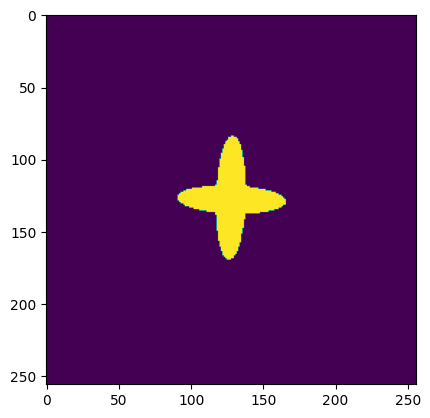

In [146]:
q0_img = np.flipud(truth_dict["truth"]).reshape(256**2,1)
q0 = df.Function(V_img)
q0.vector().set_local(q0_img[idx_img])
q0.set_allow_extrapolation(True)
q0 = df.interpolate(q0,V1)

plt.imshow(truth_dict["truth"])

# Extract vector of values in the right order
q0.vector().get_local()[idx2]

In [204]:
q0_img

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

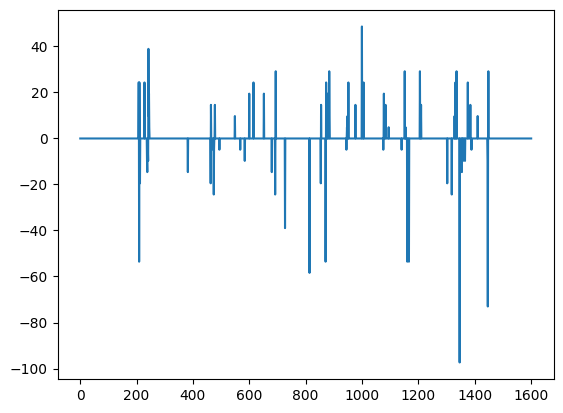